In [11]:
import data_handler
import machine_learning as ml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn import linear_model as linear
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

from tabulate import tabulate

# These are notebook magix that reloads a function each time, so if I make a change in a .py file, it is automatically reloaded.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## YOU NEED TO FIRST RUN THE TWO LAST CELLS. I HID THEM THERE SO THAT THEY DON'T USE SO MUCH SPACE.

In [4]:
def ohlson_data(year, column_names):
    x_train, x_test, y_train, y_test = data_handler.load_data(year)
    n = y_train.size
    x_train.columns = column_names
    x_test.columns = column_names

    # Ohlson use a dummy if liabilites are greater than assets
    x_train['liabilites > assets'] = (x_train[X02] > 1)*1.0
    x_test['liabilites > assets'] = (x_test[X02] > 1)*1.0
    X65 = ['liabilites > assets']

    # Try to replicate the variables as closely as possible,
    # some of the variables are inverted, but that should not affect
    # the predictability, only the sign of the coefficient.
    ohlson_var = X29 + X02 + X03 + X04 + X65 + X01 + X41 + X21
    x_ohlson_train = x_train[ohlson_var]
    x_ohlson_test = x_test[ohlson_var]
    return x_ohlson_train, x_ohlson_test, y_train, y_test
x_train, x_test, y_train, y_test = ohlson_data(5, column_names)

In [5]:
logit = linear.LogisticRegression(penalty='none', max_iter=1000)
ml.validate_model(logit, (x_train, y_train), (x_test, y_test)) ;

Confusion matrix from a LogisticRegression, with test-score of 0.244

                Non-Bankrupt    Bankrupt
------------  --------------  ----------
Non-Bankrupt            1095           5
Bankrupt                  79           3


# Elastic net

In [4]:
# Load data set
x_train, x_test, y_train, y_test = data_handler.load_data(5)

In [1]:

logit_elastic_net = linear.LogisticRegression(
    penalty='elasticnet', 
    solver='saga',
    max_iter=10000,
    l1_ratio=0.1
)

# As fortran array makes sklearn faster.
ml.validate_model(
    logit_elastic_net, 
    (np.asfortranarray(x_train.to_numpy()), y_train.to_numpy()),
    (x_test.to_numpy(), y_test.to_numpy())
) ;

NameError: name 'linear' is not defined

In [86]:
parameters = {'C': [ 0.1, 0.5, 0.9], 'l1_ratio': [ 0.1, 0.5, 0.9]}
logit_elastic_net = linear.LogisticRegression(
    penalty='elasticnet', 
    solver='saga',
    max_iter=100
)
grid_result = ml.search_hyperparameters(
    logit_elastic_net, 
    parameters, 
    (x_train, y_train), 
    scoring='recall', 
    refit=True
)

In [95]:
def loop_over_scores(
        func, parameters, x_train, y_train, scorer_list
    ):
    # Loop over different scorers, like recall, accuracy, etc.
    # Use these different scorers to optimize the hyperparameters
    # for the given ml algorithm, and then pass it to the 
    # grid_cv_reporter to get a nice overview of the results.
    for scorer in scorer_list:
        grid_result = ml.search_hyperparameters(
            func, 
            parameters, 
            (x_train, y_train), 
            scoring=scorer, 
            refit=True
        )
        print(f'Results using {scorer} scorer:')
        ml.grid_cv_report(grid_result, x_test, y_test)
        print('-'*80)
        print()

Results using roc_auc scorer:
Machine learning estimator: LogisticRegression(penalty='elasticnet', solver='saga')

                                                                                                        Specification    mean score    cf - 5%    cf - 95%
--  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  ---------------  ------------  ---------  ----------
T   o   o       m   a   n   y       c   o   m   b   i   n   a   t   i   o   n   s       t   o       p   r                i             n          t


Best specification at {'C': 0.29, 'l1_ratio': 0.01}:

              precision    recall  f1-score   support

           0      0.935     0.995     0.964      1100
           1      0.545     0.073     0.129        82

    accuracy                          0.931      1182
   macro avg      0.740     0.534     0.547      1182
weighted avg      0.908     0.931     0.906      1182




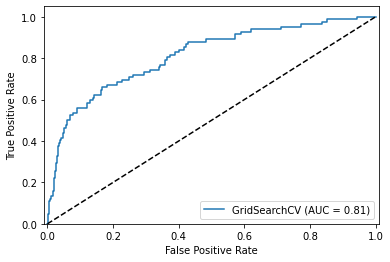


--------------------------------------------------------------------------------



In [99]:
parameters = {
    'C': np.linspace(0.01, 0.99, 10), 'l1_ratio': np.linspace(0.01, 0.99, 10)
}
logit_elastic_net = linear.LogisticRegression(
    penalty='elasticnet', 
    solver='saga',
    max_iter=100
)
scorer_list = ['recall', 'roc_auc', 'accuracy']
scorer_list = ['roc_auc']
loop_over_scores(logit_elastic_net, parameters, x_train, y_train, scorer_list)


# Regression Tree

In [7]:
gradient_boost = GradientBoostingClassifier(
    loss='deviance',
    learning_rate=0.1, n_estimators=100,
    subsample=1.0, criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3, min_impurity_split=1e-07,
    #init=Null, random_state=Null, max_features=Null,
    verbose=0, #max_leaf_nodes=Null,
    warm_start=False #, presort='auto'
)

ml.validate_model(
    gradient_boost, 
    (np.asfortranarray(x_train.to_numpy()), y_train.to_numpy()),
    (x_test.to_numpy(), y_test.to_numpy())
) ;

l/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py:306: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  warnings.warn("The min_impurity_split parameter is deprecated. "
/Users/karl/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py:306: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  warnings.warn("The min_impurity_split parameter is deprecated. "
/Users/karl/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py:306: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  warnings.warn("T

In [2]:
column_names = ['net profit / total assets','total liabilities / total assets','working capital / total assets','current assets / short-term liabilities','[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365','retained earnings / total assets','EBIT / total assets','book value of equity / total liabilities','sales / total assets','equity / total assets','(gross profit + extraordinary items + financial expenses) / total assets','gross profit / short-term liabilities','(gross profit + depreciation) / sales','(gross profit + interest) / total assets','(total liabilities * 365) / (gross profit + depreciation)','(gross profit + depreciation) / total liabilities','total assets / total liabilities','gross profit / total assets','gross profit / sales','(inventory * 365) / sales','sales (n) / sales (n-1)','profit on operating activities / total assets','net profit / sales','gross profit (in 3 years) / total assets','(equity - share capital) / total assets','(net profit + depreciation) / total liabilities','profit on operating activities / financial expenses','working capital / fixed assets','logarithm of total assets','(total liabilities - cash) / sales','(gross profit + interest) / sales','(current liabilities * 365) / cost of products sold','operating expenses / short-term liabilities','operating expenses / total liabilities','profit on sales / total assets','total sales / total assets','(current assets - inventories) / long-term liabilities','constant capital / total assets','profit on sales / sales','(current assets - inventory - receivables) / short-term liabilities','total liabilities / ((profit on operating activities + depreciation) * (12/365))','profit on operating activities / sales','rotation receivables + inventory turnover in days','(receivables * 365) / sales','net profit / inventory','(current assets - inventory) / short-term liabilities','(inventory * 365) / cost of products sold','EBITDA (profit on operating activities - depreciation) / total assets','EBITDA (profit on operating activities - depreciation) / sales','current assets / total liabilities','short-term liabilities / total assets','(short-term liabilities * 365) / cost of products sold)','equity / fixed assets','constant capital / fixed assets','working capital','(sales - cost of products sold) / sales','(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)','total costs /total sales','long-term liabilities / equity','sales / inventory','sales / receivables','(short-term liabilities *365) / sales','sales / short-term liabilities','sales / fixed assets']

In [3]:
X01 =  ['net profit / total assets']
X02 =  ['total liabilities / total assets']
X03 =  ['working capital / total assets']
X04 =  ['current assets / short-term liabilities']
X05 =  ['[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365']
X06 =  ['retained earnings / total assets']
X07 =  ['EBIT / total assets']
X08 =  ['book value of equity / total liabilities']
X09 =  ['sales / total assets']
X10 =  ['equity / total assets']
X11 =  ['(gross profit + extraordinary items + financial expenses) / total assets']
X12 =  ['gross profit / short-term liabilities']
X13 =  ['(gross profit + depreciation) / sales']
X14 =  ['(gross profit + interest) / total assets']
X15 =  ['(total liabilities * 365) / (gross profit + depreciation)']
X16 =  ['(gross profit + depreciation) / total liabilities']
X17 =  ['total assets / total liabilities']
X18 =  ['gross profit / total assets']
X19 =  ['gross profit / sales']
X20 =  ['(inventory * 365) / sales']
X21 =  ['sales (n) / sales (n-1)']
X22 =  ['profit on operating activities / total assets']
X23 =  ['net profit / sales']
X24 =  ['gross profit (in 3 years) / total assets']
X25 =  ['(equity - share capital) / total assets']
X26 =  ['(net profit + depreciation) / total liabilities']
X27 =  ['profit on operating activities / financial expenses']
X28 =  ['working capital / fixed assets']
X29 =  ['logarithm of total assets']
X30 =  ['(total liabilities - cash) / sales']
X31 =  ['(gross profit + interest) / sales']
X32 =  ['(current liabilities * 365) / cost of products sold']
X33 =  ['operating expenses / short-term liabilities']
X34 =  ['operating expenses / total liabilities']
X35 =  ['profit on sales / total assets']
X36 =  ['total sales / total assets']
X37 =  ['(current assets - inventories) / long-term liabilities']
X38 =  ['constant capital / total assets']
X39 =  ['profit on sales / sales']
X40 =  ['(current assets - inventory - receivables) / short-term liabilities']
X41 =  ['total liabilities / ((profit on operating activities + depreciation) * (12/365))']
X42 =  ['profit on operating activities / sales']
X43 =  ['rotation receivables + inventory turnover in days']
X44 =  ['(receivables * 365) / sales']
X45 =  ['net profit / inventory']
X46 =  ['(current assets - inventory) / short-term liabilities']
X47 =  ['(inventory * 365) / cost of products sold']
X48 =  ['EBITDA (profit on operating activities - depreciation) / total assets']
X49 =  ['EBITDA (profit on operating activities - depreciation) / sales']
X50 =  ['current assets / total liabilities']
X51 =  ['short-term liabilities / total assets']
X52 =  ['(short-term liabilities * 365) / cost of products sold)']
X53 =  ['equity / fixed assets']
X54 =  ['constant capital / fixed assets']
X55 =  ['working capital']
X56 =  ['(sales - cost of products sold) / sales']
X57 =  ['(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)']
X58 =  ['total costs /total sales']
X59 =  ['long-term liabilities / equity']
X60 =  ['sales / inventory']
X61 =  ['sales / receivables']
X62 =  ['(short-term liabilities *365) / sales']
X63 =  ['sales / short-term liabilities']
X64 =  ['sales / fixed assets']